Loading saved results from language_model_focus_experiment_results_multi_model.xlsx...
Successfully loaded results with 150 rows.
Creating updated visualizations...
Saving updated results to language_model_focus_experiment_results_updated.xlsx...
Updated results saved to language_model_focus_experiment_results_updated.xlsx
Visualization improvements applied:
1. Added padding to chart titles
2. Reordered positions to show: beginning, middle, end
3. Reordered injection types to show: Literal first, then Associative


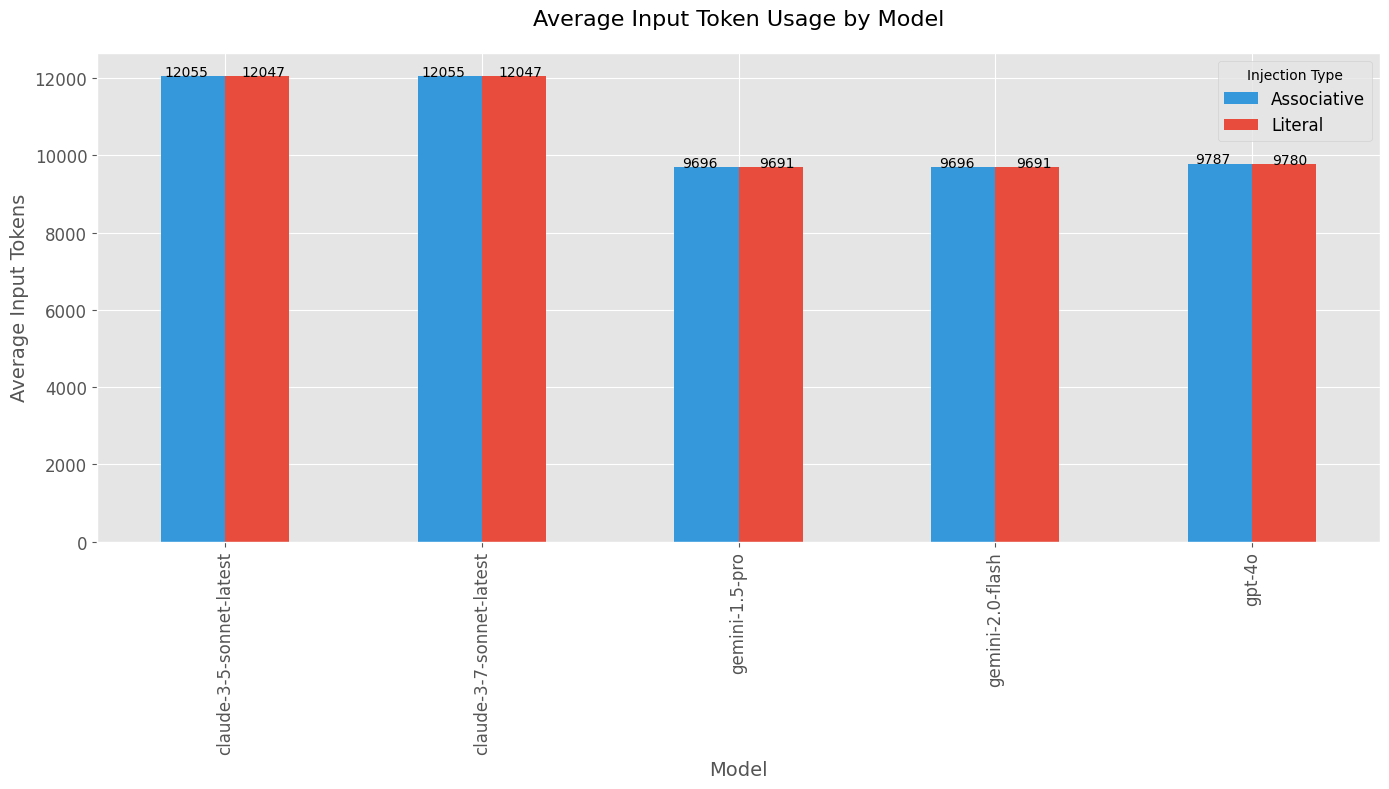

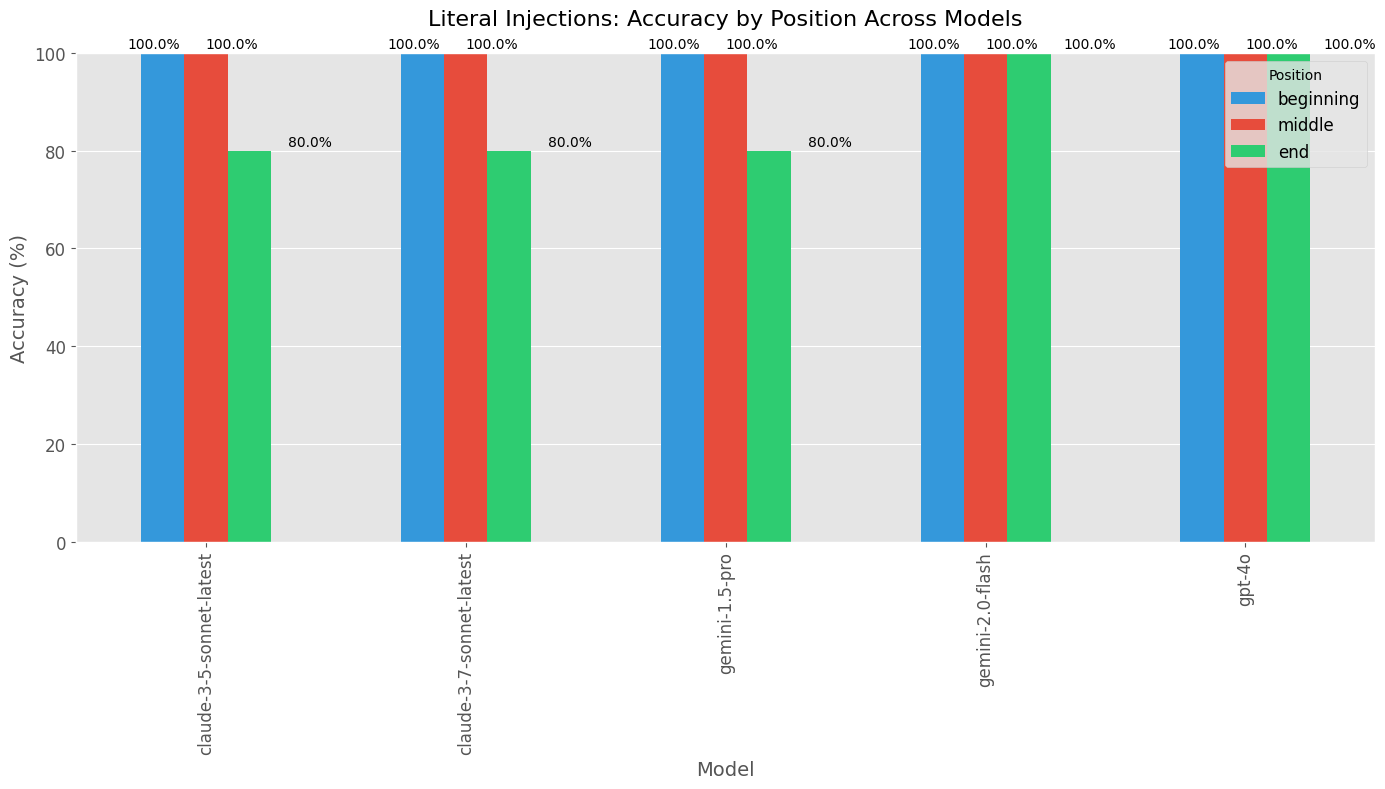

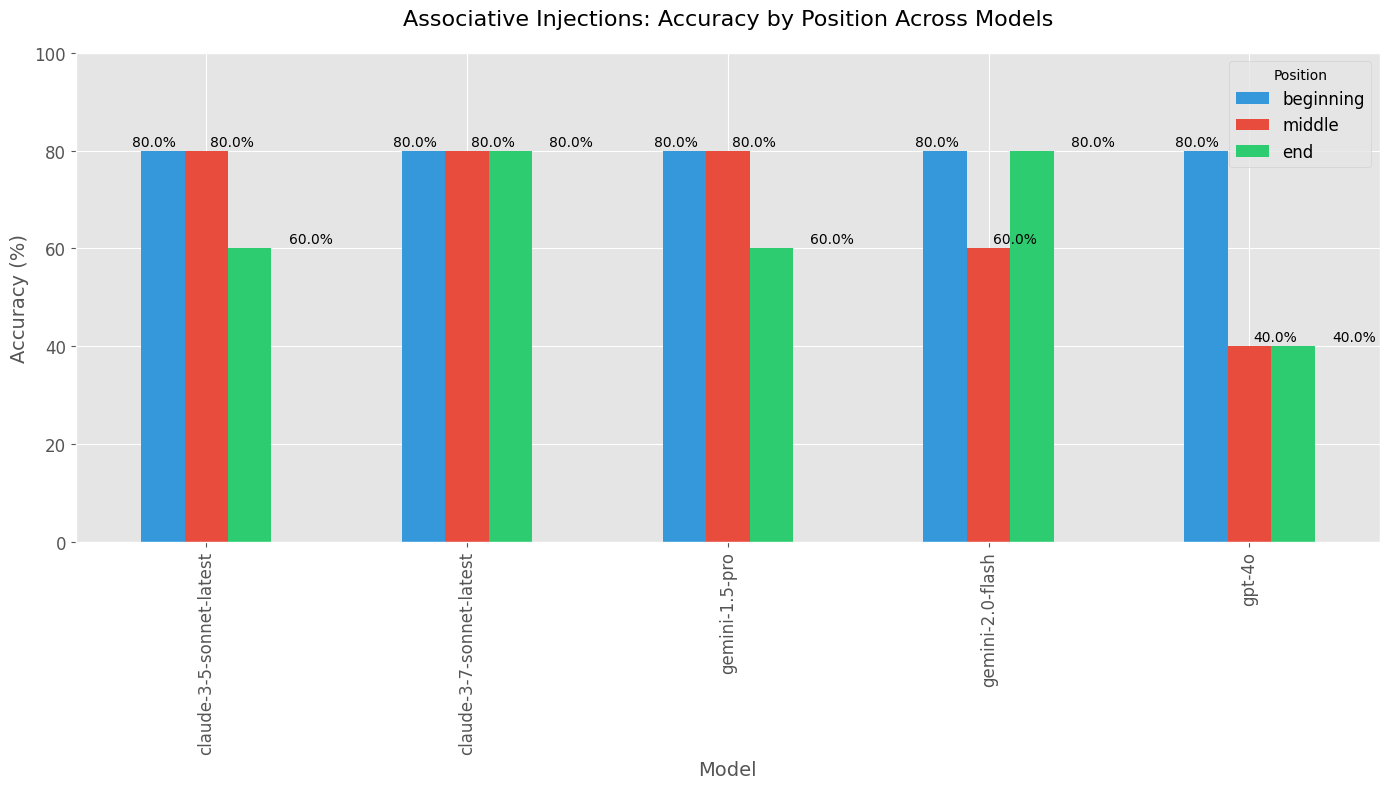

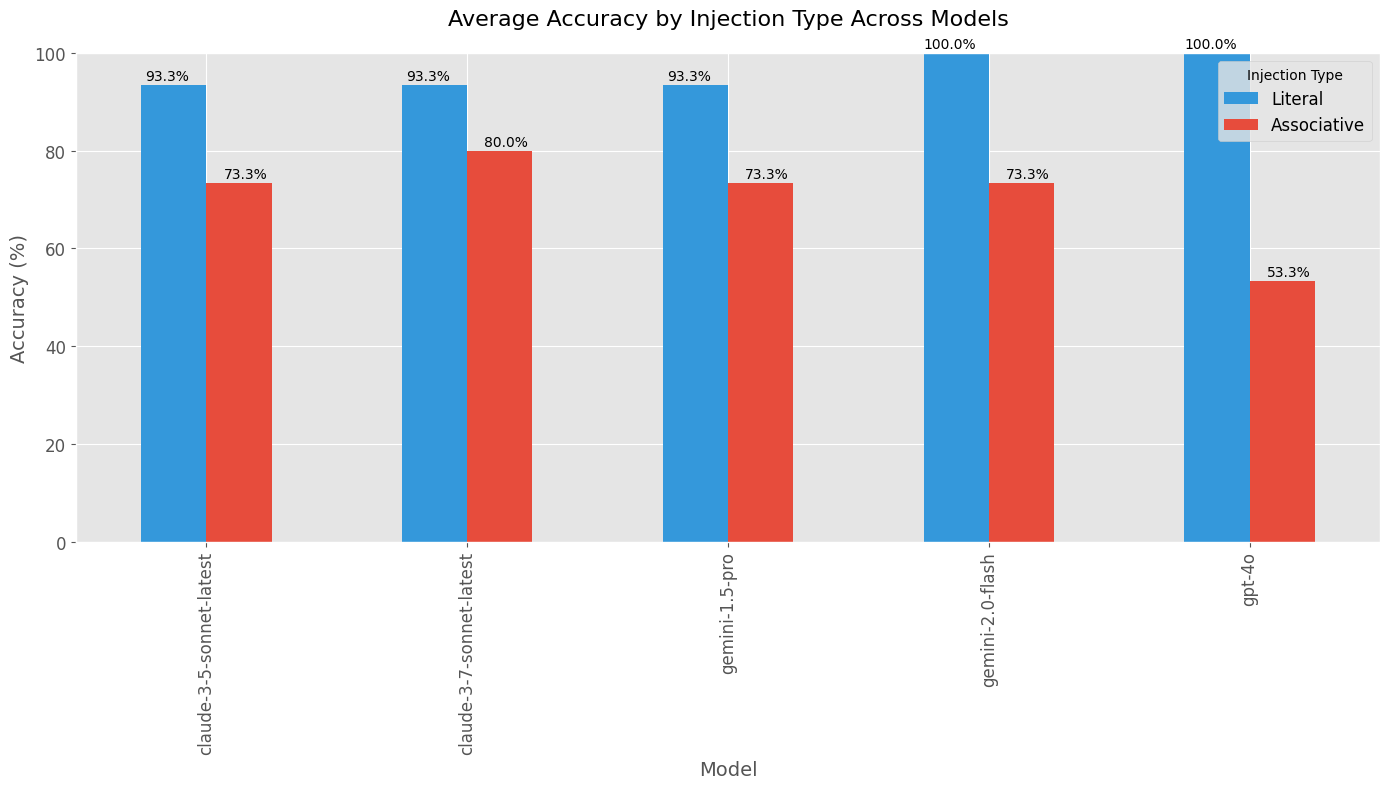

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
import xlsxwriter
from tqdm import tqdm

def create_model_comparison_visualizations(combined_results):
    """Create visualization charts comparing model performance."""
    plt.style.use('ggplot')
    figures = {}

    # Set color palette for models
    colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

    # Create tokens visualization
    fig_tokens, ax_tokens = plt.subplots(figsize=(14, 8))

    # Calculate average tokens by model and injection type
    token_usage = combined_results.groupby(['Model', 'Injection Type'])['Input Tokens'].mean().unstack()

    # Plot grouped bar chart for token usage
    token_usage.plot(kind='bar', ax=ax_tokens, color=['#3498db', '#e74c3c'])

    ax_tokens.set_title('Average Input Token Usage by Model', fontsize=16, pad=20)
    ax_tokens.set_ylabel('Average Input Tokens', fontsize=14)
    ax_tokens.set_xlabel('Model', fontsize=14)
    ax_tokens.legend(title='Injection Type', fontsize=12)
    ax_tokens.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(token_usage.index):
        for j, inj_type in enumerate(token_usage.columns):
            value = token_usage.loc[model, inj_type]
            ax_tokens.text(i - 0.15 + (j * 0.3), value + 5, f"{value:.0f}", ha='center', fontsize=10)

    plt.tight_layout()
    figures['token_usage'] = fig_tokens

    # Figure 1: Literal injections accuracy by position for each model
    fig1, ax1 = plt.subplots(figsize=(14, 8))

    # Filter for literal injections only
    literal_results = combined_results[combined_results['Injection Type'] == 'Literal']

    # Create pivot table: Model x Position -> Accuracy
    # Force specific position order
    position_order = ['beginning', 'middle', 'end']
    literal_pivot = literal_results.pivot_table(
        index='Model',
        columns='Position',
        values='Correct Answer',
        aggfunc='mean'
    ) * 100

    # Reorder columns to ensure consistent order
    literal_pivot = literal_pivot[position_order]

    # Plot grouped bar chart
    literal_pivot.plot(kind='bar', ax=ax1, color=colors[:len(literal_pivot.columns)])

    ax1.set_title('Literal Injections: Accuracy by Position Across Models', fontsize=16, pad=20)
    ax1.set_ylabel('Accuracy (%)', fontsize=14)
    ax1.set_xlabel('Model', fontsize=14)
    ax1.set_ylim(0, 100)
    ax1.legend(title='Position', fontsize=12)
    ax1.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(literal_pivot.index):
        for j, position in enumerate(position_order):
            if position in literal_pivot.columns:
                value = literal_pivot.loc[model, position]
                ax1.text(i - 0.2 + (j * 0.3), value + 1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.tight_layout()
    figures['literal_by_position'] = fig1

    # Figure 2: Associative injections accuracy by position for each model
    fig2, ax2 = plt.subplots(figsize=(14, 8))

    # Filter for associative injections only
    associative_results = combined_results[combined_results['Injection Type'] == 'Associative']

    # Create pivot table: Model x Position -> Accuracy with specific position order
    associative_pivot = associative_results.pivot_table(
        index='Model',
        columns='Position',
        values='Correct Answer',
        aggfunc='mean'
    ) * 100

    # Reorder columns to ensure consistent order
    associative_pivot = associative_pivot[position_order]

    # Plot grouped bar chart
    associative_pivot.plot(kind='bar', ax=ax2, color=colors[:len(associative_pivot.columns)])

    ax2.set_title('Associative Injections: Accuracy by Position Across Models', fontsize=16, pad=20)
    ax2.set_ylabel('Accuracy (%)', fontsize=14)
    ax2.set_xlabel('Model', fontsize=14)
    ax2.set_ylim(0, 100)
    ax2.legend(title='Position', fontsize=12)
    ax2.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(associative_pivot.index):
        for j, position in enumerate(position_order):
            if position in associative_pivot.columns:
                value = associative_pivot.loc[model, position]
                ax2.text(i - 0.2 + (j * 0.3), value + 1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.tight_layout()
    figures['associative_by_position'] = fig2

    # Figure 3: Average accuracy by injection type for each model
    fig3, ax3 = plt.subplots(figsize=(14, 8))

    # Create pivot table: Model x Injection Type -> Accuracy
    # Ensure the order - Literal first, then Associative
    injection_type_order = ['Literal', 'Associative']
    avg_pivot = combined_results.pivot_table(
        index='Model',
        columns='Injection Type',
        values='Correct Answer',
        aggfunc='mean'
    ) * 100

    # Reorder columns to ensure Literal first, then Associative
    avg_pivot = avg_pivot[injection_type_order]

    # Plot grouped bar chart with specified colors
    avg_pivot.plot(kind='bar', ax=ax3, color=['#3498db', '#e74c3c'])

    ax3.set_title('Average Accuracy by Injection Type Across Models', fontsize=16, pad=20)
    ax3.set_ylabel('Accuracy (%)', fontsize=14)
    ax3.set_xlabel('Model', fontsize=14)
    ax3.set_ylim(0, 100)
    ax3.legend(title='Injection Type', fontsize=12)
    ax3.tick_params(axis='both', labelsize=12)

    # Add values on top of bars
    for i, model in enumerate(avg_pivot.index):
        for j, inj_type in enumerate(injection_type_order):
            if inj_type in avg_pivot.columns:
                value = avg_pivot.loc[model, inj_type]
                ax3.text(i - 0.15 + (j * 0.3), value + 1, f"{value:.1f}%", ha='center', fontsize=10)

    plt.tight_layout()
    figures['avg_by_type'] = fig3

    return figures

def save_comparison_visualizations_to_excel(excel_writer, figures):
    """Save the visualization figures to the Excel file."""
    for name, fig in figures.items():
        # Save figure to a bytes buffer
        buf = BytesIO()
        fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)

        # Create a worksheet for the figure
        worksheet = excel_writer.book.add_worksheet(f'Chart - {name}')

        # Insert the image into the worksheet
        worksheet.insert_image('B2', '', {'image_data': buf})

        # Adjust column width and row height
        worksheet.set_column('B:B', 120)
        worksheet.set_row(1, 500)

def main():
    # Path to the results file
    results_path = "language_model_focus_experiment_results_multi_model.xlsx"

    # Check if the file exists
    if not os.path.exists(results_path):
        print(f"Error: Results file {results_path} not found!")
        return

    # Load the previously saved results
    print(f"Loading saved results from {results_path}...")
    try:
        combined_results = pd.read_excel(results_path, sheet_name='All Results')
        model_comparison = pd.read_excel(results_path, sheet_name='Model Comparison')
        print(f"Successfully loaded results with {len(combined_results)} rows.")
    except Exception as e:
        print(f"Error loading results: {str(e)}")
        return

    # Convert boolean strings if needed (Excel might convert True/False to strings)
    if isinstance(combined_results['Correct Answer'].iloc[0], str):
        combined_results['Correct Answer'] = combined_results['Correct Answer'].map({'True': True, 'False': False})

    # Recreate the visualizations with the requested modifications
    print("Creating updated visualizations...")
    comparison_figures = create_model_comparison_visualizations(combined_results)

    # Save updated results
    output_path = "language_model_focus_experiment_results_updated.xlsx"
    print(f"Saving updated results to {output_path}...")

    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        # Save raw data
        combined_results.to_excel(writer, sheet_name='All Results', index=False)
        model_comparison.to_excel(writer, sheet_name='Model Comparison', index=False)

        # Create a dedicated token analysis sheet
        token_analysis = combined_results.groupby(['Model', 'Injection Type', 'Position'])['Input Tokens'].agg(['mean', 'sum', 'count']).reset_index()
        token_analysis.rename(columns={'mean': 'Avg Tokens', 'sum': 'Total Tokens', 'count': 'Sample Count'}, inplace=True)
        token_analysis.to_excel(writer, sheet_name='Token Analysis', index=False)

        # Save position comparison - create this from combined_results
        position_comparison = combined_results.pivot_table(
            index=['Model', 'Position'],
            columns='Injection Type',
            values='Correct Answer',
            aggfunc='mean'
        ).reset_index()

        # Save each position to a separate sheet
        for position in ['beginning', 'middle', 'end']:
            pos_data = position_comparison[position_comparison['Position'] == position]
            pos_data.to_excel(writer, sheet_name=f'Position - {position}', index=False)

        # Save updated visualizations
        save_comparison_visualizations_to_excel(writer, comparison_figures)

    print(f"Updated results saved to {output_path}")
    print("Visualization improvements applied:")
    print("1. Added padding to chart titles")
    print("2. Reordered positions to show: beginning, middle, end")
    print("3. Reordered injection types to show: Literal first, then Associative")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/vladyslav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Загрузка сохраненных результатов из language_model_focus_experiment_results_multi_model.xlsx...
Успешно загружены результаты с 150 строками.
Выполнение расширенного анализа результатов...
Создание расширенных визуализаций...
Сохранение расширенных результатов в language_model_focus_experiment_results_enhanced.xlsx...
Расширенные результаты сохранены в language_model_focus_experiment_results_enhanced.xlsx
Улучшения в анализе:
1. Добавлена детальная оценка качества ответов
2. Улучшенное определение корректности ответов
3. Анализ уверенности модели в ответах
4. Оценка риска выдумывания информации
5. Расширенный набор визуализаций


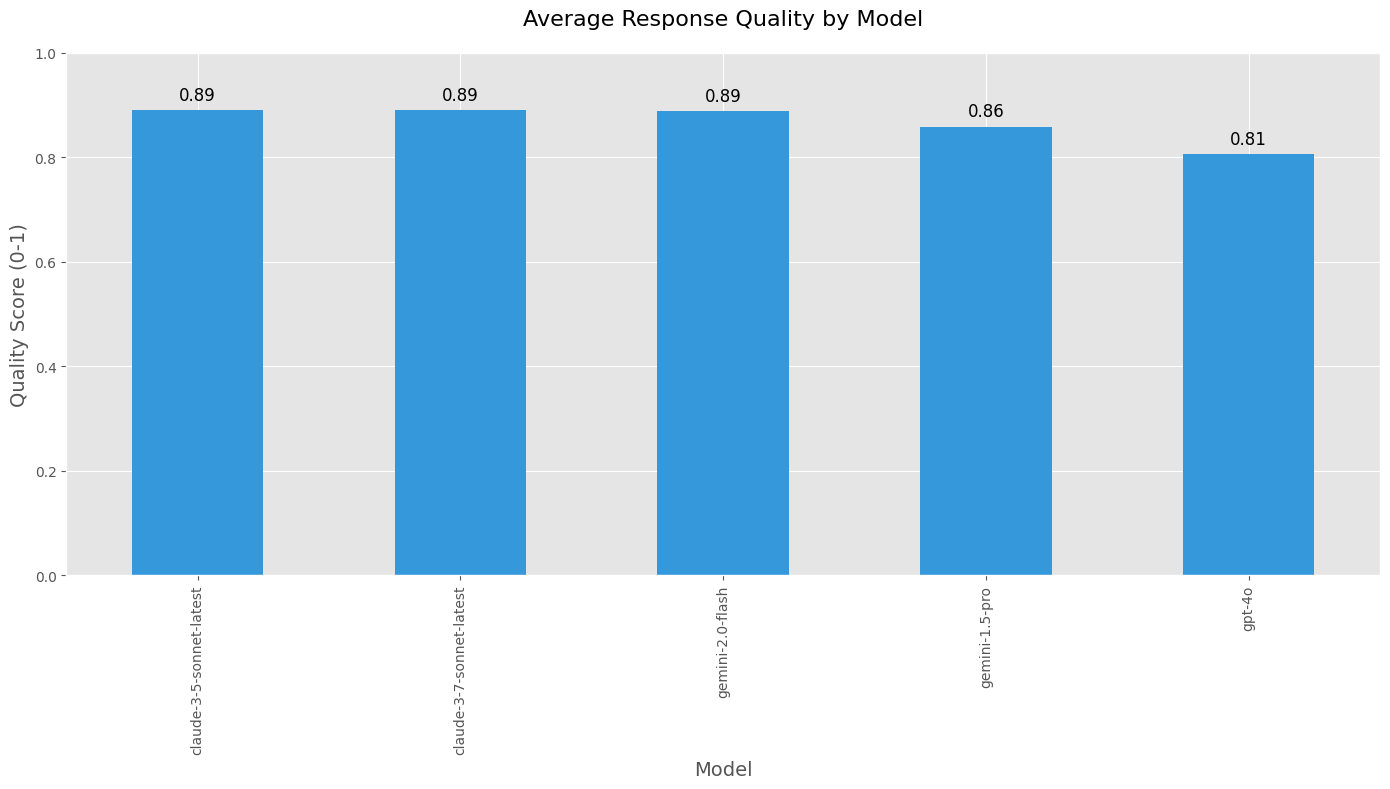

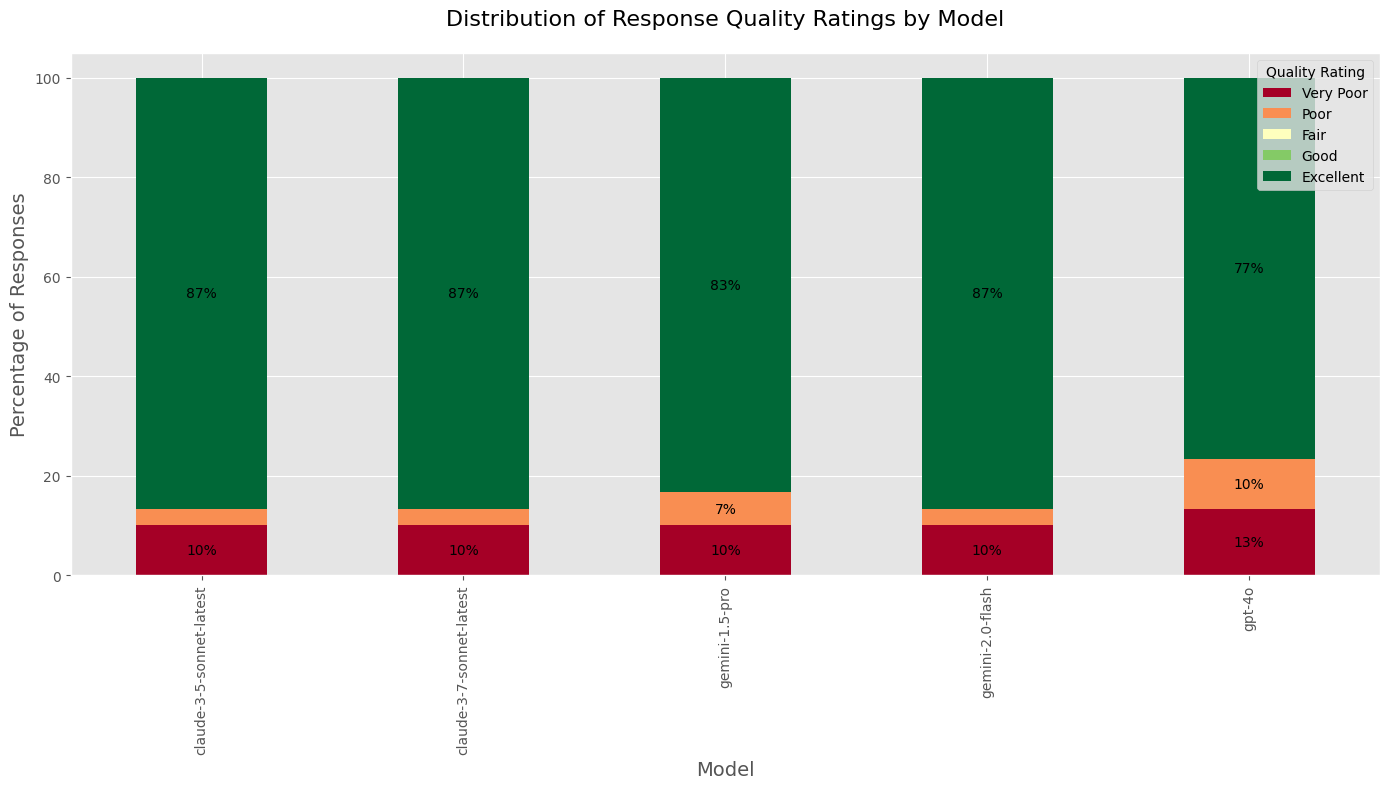

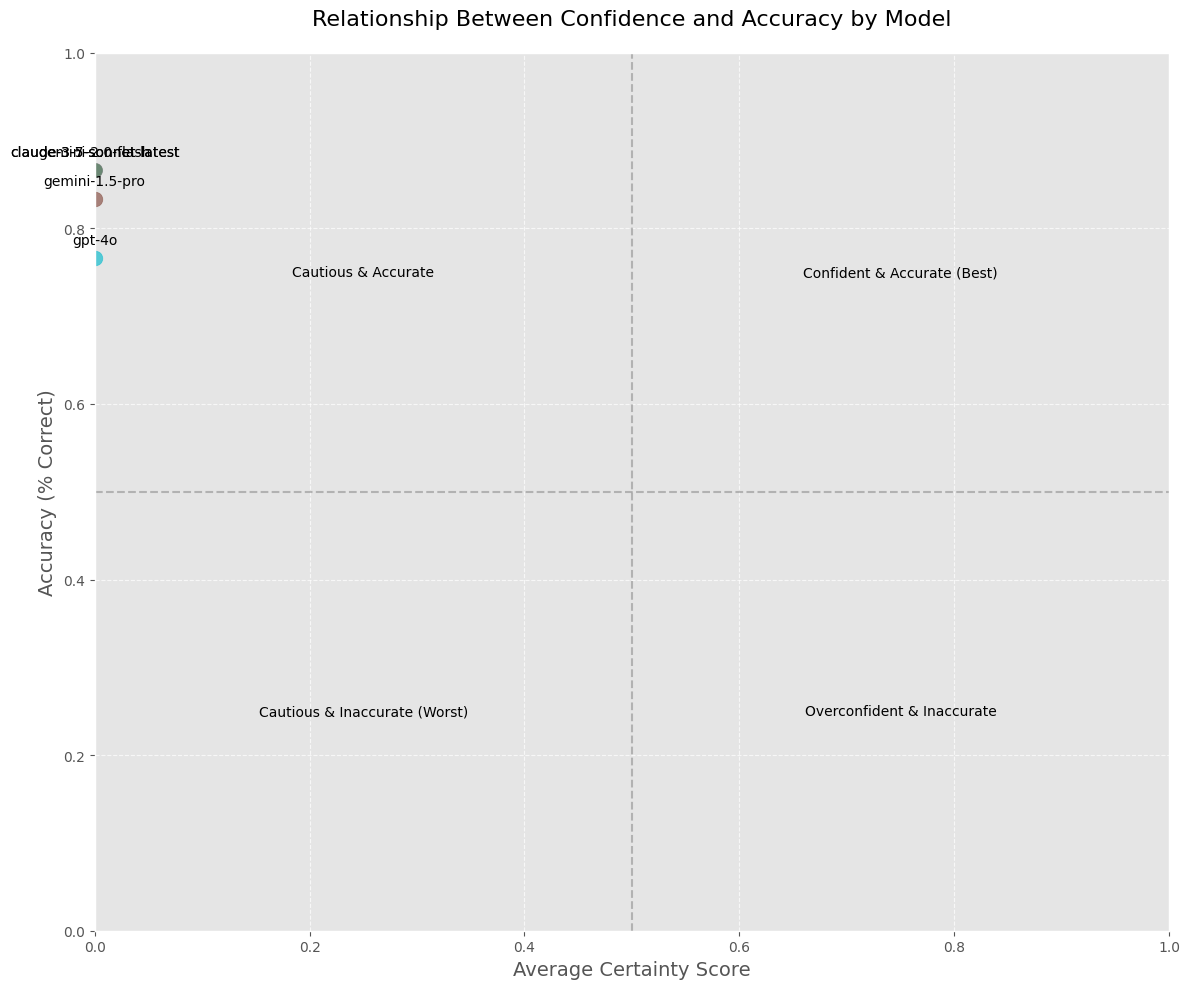

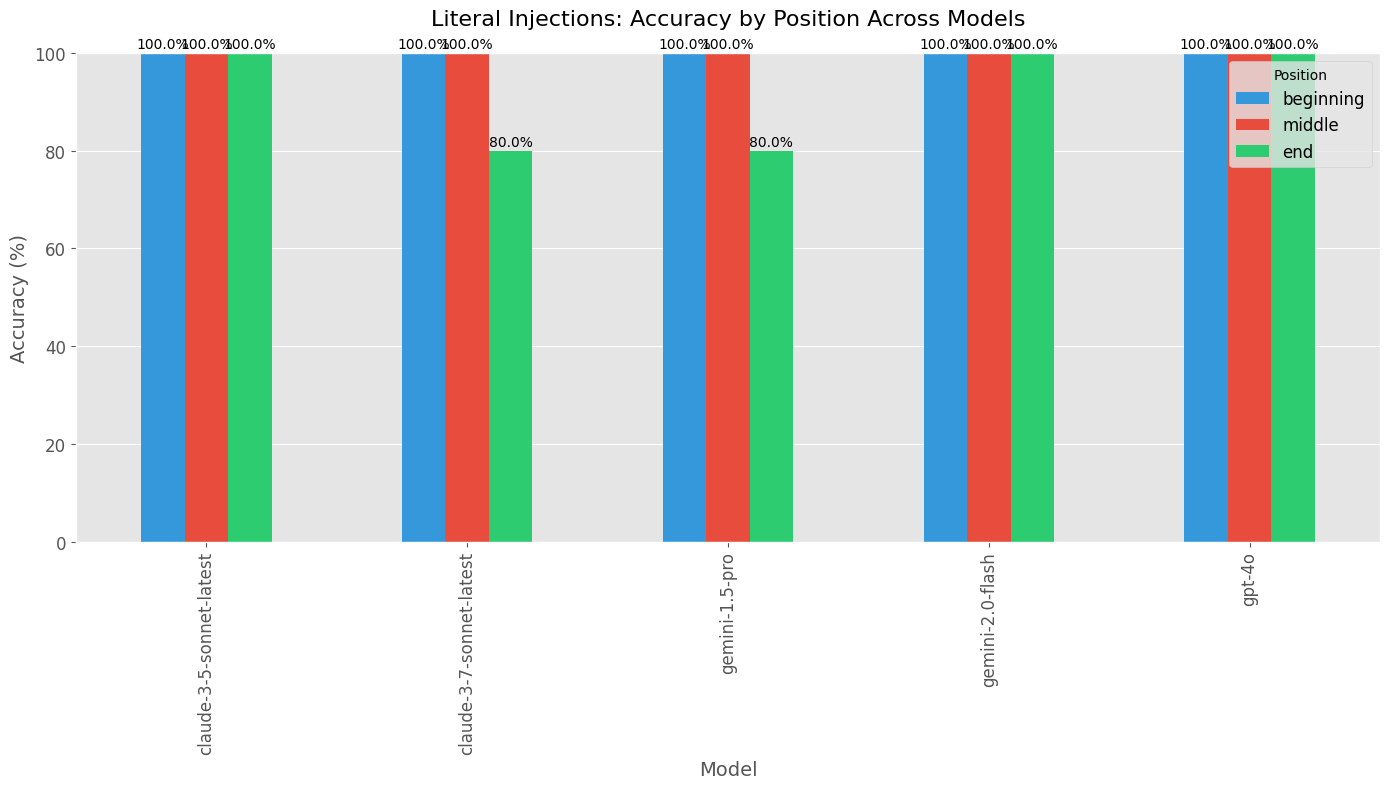

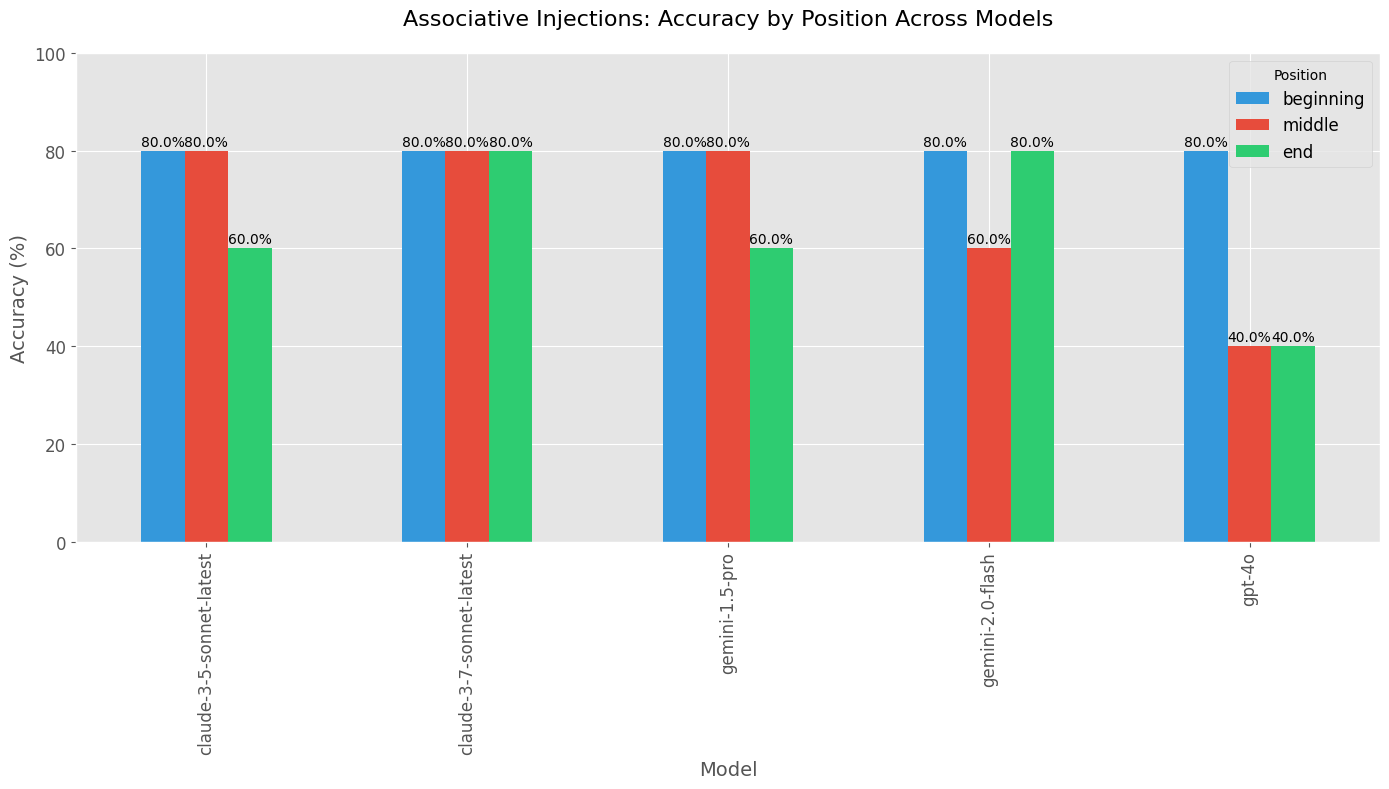

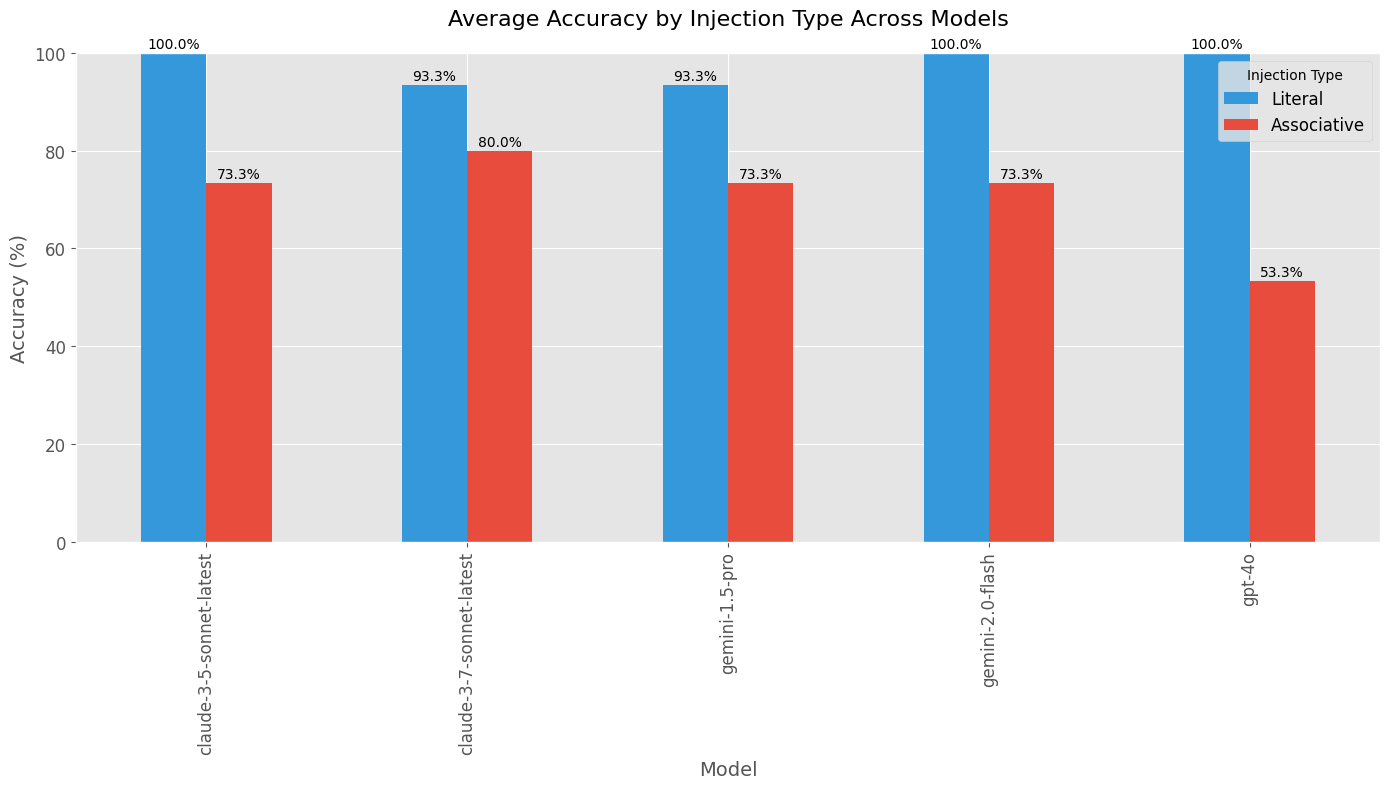

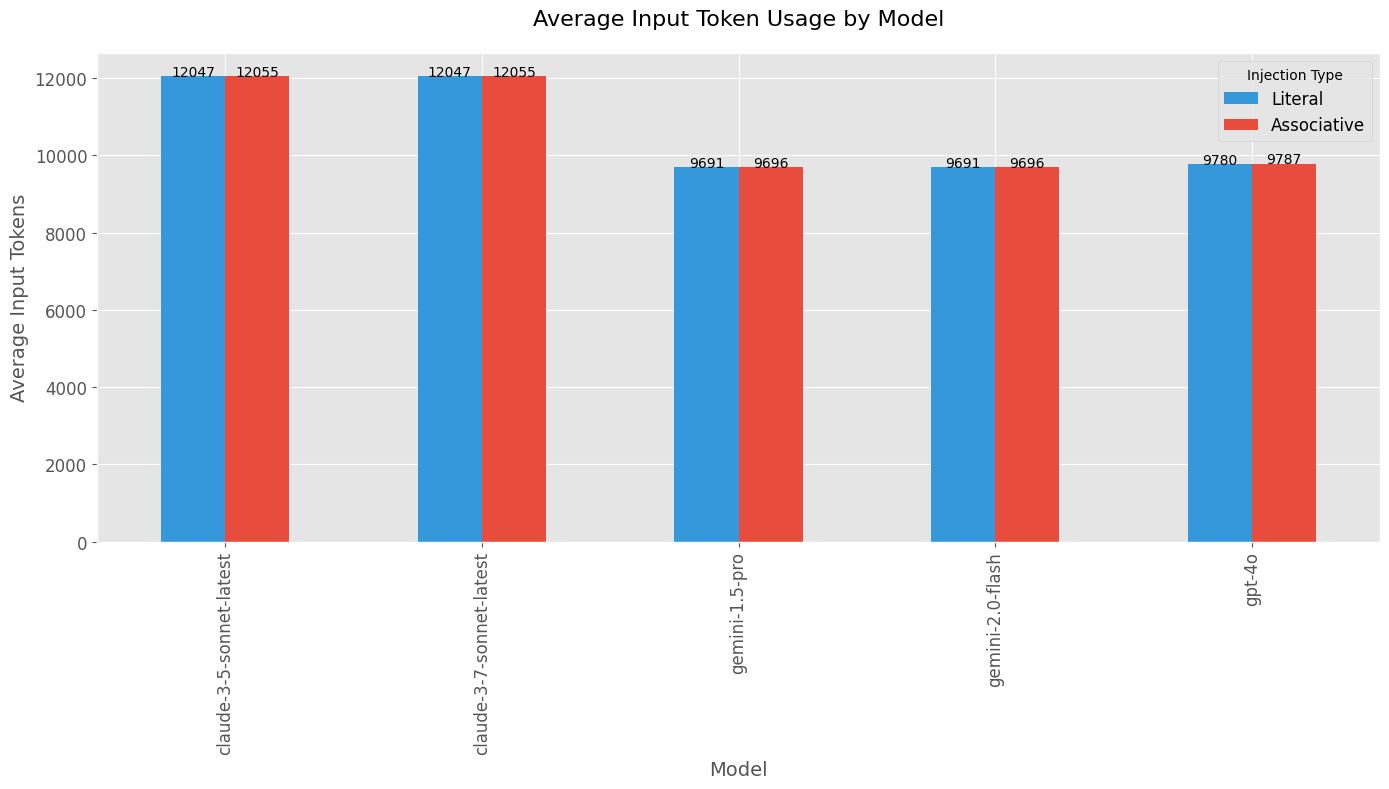

In [9]:
import numpy as np
import nltk


nltk.download('punkt_tab')


def analyze_literal_responses(df):
    """Улучшенный анализ ответов на буквальные инъекции."""
    # Определение ожидаемых ответов для буквальных инъекций
    literal_answers = {
        "Коли народився Максим?": ["весняного рівнодення", "день весняного рівнодення", "21 березня", "20 березня"],
        "Який напій любив Захар Беркут?": ["медовуха", "медовуху"],
        "Кого втратив Тугар Вовк у бою під Опором?": ["коня", "свого коня"],
        "Яку шаблю мав Бурунда-бегадир?": ["чорну шаблю з червоним руків'ям", "чорну", "з червоним руків'ям", "шаблю з червоним руків'ям", "чорну шаблю"],
        "Скільки хат було в селі Тухля?": ["137", "сто тридцять сім"]
    }

    # Инициализация новых колонок для детального анализасором, уника, зрад
    df['Match Type'] = "No Match"
    df['Score'] = 0.0

    for idx, row in df.iterrows():
        if row['Injection Type'] == 'Literal':
            question = row['Question']
            response = row['Response'].lower()

            if question in literal_answers:
                expected_answers = literal_answers[question]

                # Проверка полного соответствия
                for answer in expected_answers:
                    if answer.lower() in response:
                        df.at[idx, 'Correct Answer'] = True
                        df.at[idx, 'Match Type'] = "Direct Match"
                        df.at[idx, 'Score'] = 1.0
                        break

                # Если полного соответствия нет, проверяем частичное соответствие
                if not df.at[idx, 'Correct Answer']:
                    # Разбиваем ответы на ключевые слова
                    keywords = []
                    for answer in expected_answers:
                        keywords.extend(answer.lower().split())

                    # Проверяем, сколько ключевых слов присутствует в ответе
                    matches = sum(1 for word in set(keywords) if word in response)

                    if matches > 0:
                        # Рассчитываем процент соответствия
                        match_percent = matches / len(set(keywords))

                        if match_percent >= 0.5:  # Если есть хотя бы 50% ключевых слов
                            df.at[idx, 'Correct Answer'] = True
                            df.at[idx, 'Match Type'] = "Partial Match"
                            df.at[idx, 'Score'] = match_percent
                        else:
                            df.at[idx, 'Match Type'] = "Weak Match"
                            df.at[idx, 'Score'] = match_percent

    return df

def analyze_associative_responses(df):
    """Улучшенный анализ ответов на ассоциативные инъекции."""
    # Расширенный набор ключевых слов и концепций для ассоциативных вопросов
    key_concepts = {
        "Як проявлялася доброта Захара Беркута?": {
            "primary": ["хліб", "дитин", "сусідн", "віддав"],
            "secondary": ["допомог", "доброт", "щедр", "турбот"],
        },
        "Що допомагало Мирославі згадувати рідний край?": {
            "primary": ["спів", "вітр", "гор", "ночами"],
            "secondary": ["слуха", "звук", "природ", "згадува"],
        },
        "Як Максим проявив витривалість?": {
            "primary": ["босоніж", "сніг", "кривав", "слід"],
            "secondary": ["йшов", "через", "холод", "біль"],
        },
        "Яке духовне значення мала тіснина для громади?": {
            "primary": ["священ", "поріг", "світ", "між"],
            "secondary": ["дух", "віра", "символ", "значенн"],
        },
        "Як ставився Тугар Вовк до теми честі?": {
            "primary": ["хова", "очі", "говорили"],
            "secondary": ["сором", "уника", "зрад"],
        }
    }

    # Инициализация новых колонок для детального анализа
    df['Primary Matches'] = 0
    df['Secondary Matches'] = 0
    df['Context Matches'] = 0
    df['Total Weight'] = 0.0

    for idx, row in df.iterrows():
        if row['Injection Type'] == 'Associative':
            question = row['Question']
            response = row['Response'].lower()

            if question in key_concepts:
                concepts = key_concepts[question]

                # Подсчет совпадений по каждой категории
                primary_matches = sum(1 for kw in concepts["primary"] if kw in response)
                secondary_matches = sum(1 for kw in concepts["secondary"] if kw in response)

                # Запись результатов
                df.at[idx, 'Primary Matches'] = primary_matches
                df.at[idx, 'Secondary Matches'] = secondary_matches

                # Вычисление взвешенной суммы (первичные ключевые слова важнее)
                weight = (primary_matches * 3 + secondary_matches * 2) / \
                        (len(concepts["primary"]) * 3 + len(concepts["secondary"]) * 2)

                df.at[idx, 'Total Weight'] = weight

                # Определение корректности ответа
                if primary_matches >= len(concepts["primary"]) * 0.6 or weight >= 0.5:
                    df.at[idx, 'Correct Answer'] = True
                    df.at[idx, 'Score'] = weight

                    if weight >= 0.7:
                        df.at[idx, 'Match Type'] = "Strong Match"
                    else:
                        df.at[idx, 'Match Type'] = "Moderate Match"
                else:
                    df.at[idx, 'Match Type'] = "Weak Match"
                    df.at[idx, 'Score'] = weight

    return df

def perform_semantic_analysis(df):
    """Выполнить семантический анализ ответов с использованием простых NLP-методов."""
    try:
        import nltk
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords

        # Загрузка необходимых ресурсов NLTK
        try:
            nltk.data.find('tokenizers/punkt')
            nltk.data.find('corpora/stopwords')
        except LookupError:
            nltk.download('punkt')
            nltk.download('stopwords')

        # Создаем набор стоп-слов для украинского языка
        # Если у NLTK нет украинских стоп-слов, используем базовый набор
        try:
            stop_words = set(stopwords.words('ukrainian'))
        except:
            # Базовый набор украинских стоп-слов
            stop_words = {"і", "в", "на", "з", "до", "за", "у", "від", "це", "той", "а", "але", "що", "як", "чи", "не", "так", "та"}

        # Добавление новых колонок для анализа
        df['Token Count'] = 0
        df['Unique Words'] = 0
        df['Content Density'] = 0.0

        for idx, row in df.iterrows():
            response = row['Response'].lower()

            # Токенизация
            tokens = word_tokenize(response)
            df.at[idx, 'Token Count'] = len(tokens)

            # Удаление стоп-слов и подсчет уникальных значимых слов
            meaningful_words = [word for word in tokens if word.isalpha() and word not in stop_words]
            unique_words = set(meaningful_words)
            df.at[idx, 'Unique Words'] = len(unique_words)

            # Расчет плотности содержания (доля значимых слов)
            if len(tokens) > 0:
                df.at[idx, 'Content Density'] = len(meaningful_words) / len(tokens)

        return df

    except ImportError:
        print("NLTK не установлен. Семантический анализ пропущен.")
        return df

def analyze_confidence(df):
    """Анализ уверенности модели в ответах."""
    # Слова/фразы, указывающие на неуверенность
    uncertainty_markers = [
        "можливо", "ймовірно", "здається", "може бути", "припускаю", "я думаю",
        "я вважаю", "не впевнений", "не зовсім впевнений", "важко сказати"
    ]

    # Слова/фразы, указывающие на уверенность
    certainty_markers = [
        "точно", "безперечно", "безсумнівно", "достовірно", "однозначно",
        "чітко", "напевно", "саме так", "звичайно", "справді"
    ]

    # Индикаторы ложной информации
    fabrication_markers = [
        "також у тексті згадується", "у творі описано", "автор розповідає",
        "в оповіданні", "як зазначено в тексті", "згідно з текстом"
    ]

    # Добавление колонок для анализа
    df['Uncertainty Score'] = 0.0
    df['Certainty Score'] = 0.0
    df['Fabrication Risk'] = 0.0
    df['Confidence Level'] = ""

    for idx, row in df.iterrows():
        response = row['Response'].lower()

        # Подсчет маркеров неуверенности
        uncertainty_count = sum(1 for marker in uncertainty_markers if marker in response)
        uncertainty_score = min(1.0, uncertainty_count / 3)  # Нормализация (максимум 1.0)
        df.at[idx, 'Uncertainty Score'] = uncertainty_score

        # Подсчет маркеров уверенности
        certainty_count = sum(1 for marker in certainty_markers if marker in response)
        certainty_score = min(1.0, certainty_count / 3)  # Нормализация (максимум 1.0)
        df.at[idx, 'Certainty Score'] = certainty_score

        # Оценка риска выдумывания информации
        fabrication_count = sum(1 for marker in fabrication_markers if marker in response)
        fabrication_risk = min(1.0, fabrication_count / 2)  # Нормализация (максимум 1.0)
        df.at[idx, 'Fabrication Risk'] = fabrication_risk

        # Определение общего уровня уверенности
        confidence_level = certainty_score - uncertainty_score - fabrication_risk

        if confidence_level >= 0.5:
            df.at[idx, 'Confidence Level'] = "High"
        elif confidence_level >= 0:
            df.at[idx, 'Confidence Level'] = "Medium"
        else:
            df.at[idx, 'Confidence Level'] = "Low"

    return df

def calculate_response_quality(df):
    """Вычисление комплексной оценки качества ответов."""
    # Инициализация колонки для итоговой оценки
    df['Quality Score'] = 0.0
    df['Quality Rating'] = ""

    for idx, row in df.iterrows():
        # Базовая оценка на основе корректности ответа
        base_score = 1.0 if row['Correct Answer'] else 0.0

        # Учет уровня совпадения
        match_factor = 0.0
        if 'Score' in df.columns:
            match_factor = row['Score']

        # Учет уровня уверенности
        confidence_factor = 0.0
        if 'Confidence Level' in df.columns:
            if row['Confidence Level'] == "High":
                confidence_factor = 0.2
            elif row['Confidence Level'] == "Medium":
                confidence_factor = 0.1

            # Штраф за неоправданную уверенность или неуверенность
            if row['Correct Answer'] and row['Uncertainty Score'] > 0.5:
                confidence_factor -= 0.1  # Штраф за неуверенность при правильном ответе
            elif not row['Correct Answer'] and row['Certainty Score'] > 0.5:
                confidence_factor -= 0.2  # Штраф за уверенность при неправильном ответе

        # Штраф за риск выдумывания
        fabrication_penalty = 0.0
        if 'Fabrication Risk' in df.columns:
            fabrication_penalty = row['Fabrication Risk'] * 0.3

        # Бонус за содержательность
        content_bonus = 0.0
        if 'Content Density' in df.columns and 'Unique Words' in df.columns:
            if row['Content Density'] > 0.7 and row['Unique Words'] > 15:
                content_bonus = 0.1

        # Вычисление итоговой оценки
        quality_score = base_score + match_factor * 0.5 + confidence_factor - fabrication_penalty + content_bonus
        quality_score = max(0.0, min(1.0, quality_score))  # Ограничение в диапазоне [0, 1]

        df.at[idx, 'Quality Score'] = quality_score

        # Определение рейтинга качества
        if quality_score >= 0.8:
            df.at[idx, 'Quality Rating'] = "Excellent"
        elif quality_score >= 0.6:
            df.at[idx, 'Quality Rating'] = "Good"
        elif quality_score >= 0.4:
            df.at[idx, 'Quality Rating'] = "Fair"
        elif quality_score >= 0.2:
            df.at[idx, 'Quality Rating'] = "Poor"
        else:
            df.at[idx, 'Quality Rating'] = "Very Poor"

    return df

def analyze_results_improved(df):
    """Улучшенный комплексный анализ результатов."""
    # Базовая подготовка данных
    if 'Correct Answer' not in df.columns:
        df['Correct Answer'] = False

    # Применение всех улучшенных алгоритмов анализа
    df = analyze_literal_responses(df)
    df = analyze_associative_responses(df)
    df = perform_semantic_analysis(df)
    df = analyze_confidence(df)
    df = calculate_response_quality(df)

    return df

def create_enhanced_visualizations(df):
    """Создание улучшенных визуализаций результатов."""
    plt.style.use('ggplot')
    figures = {}

    # Визуализация по качеству ответов
    fig_quality, ax_quality = plt.subplots(figsize=(14, 8))

    quality_by_model = df.groupby(['Model'])['Quality Score'].mean().sort_values(ascending=False)
    quality_by_model.plot(kind='bar', ax=ax_quality, color='#3498db')

    ax_quality.set_title('Average Response Quality by Model', fontsize=16, pad=20)
    ax_quality.set_ylabel('Quality Score (0-1)', fontsize=14)
    ax_quality.set_xlabel('Model', fontsize=14)
    ax_quality.set_ylim(0, 1)

    # Добавление значений над столбцами
    for i, v in enumerate(quality_by_model):
        ax_quality.text(i, v + 0.02, f"{v:.2f}", ha='center', fontsize=12)

    plt.tight_layout()
    figures['quality_by_model'] = fig_quality

    # Визуализация распределения рейтингов качества
    fig_ratings, ax_ratings = plt.subplots(figsize=(14, 8))

    # Подсчет количества ответов по категориям для каждой модели
    rating_counts = df.pivot_table(
        index='Model',
        columns='Quality Rating',
        values='Quality Score',
        aggfunc='count',
        fill_value=0
    )

    # Обеспечение последовательности категорий от низшей к высшей
    rating_order = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
    for rating in rating_order:
        if rating not in rating_counts.columns:
            rating_counts[rating] = 0

    rating_counts = rating_counts[rating_order]

    # Преобразование в проценты
    rating_percents = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

    # Построение 100% stacked bar chart
    rating_percents.plot(kind='bar', stacked=True, ax=ax_ratings,
                         colormap='RdYlGn')

    ax_ratings.set_title('Distribution of Response Quality Ratings by Model', fontsize=16, pad=20)
    ax_ratings.set_ylabel('Percentage of Responses', fontsize=14)
    ax_ratings.set_xlabel('Model', fontsize=14)
    ax_ratings.legend(title='Quality Rating')

    # Добавление процентов в столбцы
    for n, x in enumerate(rating_percents.index):
        cumulative = 0
        for p, col in enumerate(rating_percents.columns):
            value = rating_percents.loc[x, col]
            if value > 5:  # Показывать только метки для значений > 5%
                ax_ratings.text(n, cumulative + value/2, f"{value:.0f}%",
                               ha='center', va='center', fontsize=10)
            cumulative += value

    plt.tight_layout()
    figures['quality_ratings'] = fig_ratings

    # Диаграмма рассеяния: Соотношение уверенности и точности
    fig_scatter, ax_scatter = plt.subplots(figsize=(12, 10))

    # Вычисление средних значений уверенности и точности для каждой модели
    scatter_data = df.groupby('Model').agg({
        'Certainty Score': 'mean',
        'Correct Answer': 'mean',
        'Fabrication Risk': 'mean'
    }).reset_index()

    # Размер точек пропорционален обратному значению риска выдумывания
    sizes = 100 * (1.1 - scatter_data['Fabrication Risk'])

    # Создание диаграммы рассеяния
    colors = plt.cm.tab10(np.linspace(0, 1, len(scatter_data)))

    for i, model in enumerate(scatter_data['Model']):
        ax_scatter.scatter(
            scatter_data.loc[scatter_data['Model'] == model, 'Certainty Score'],
            scatter_data.loc[scatter_data['Model'] == model, 'Correct Answer'],
            s=sizes[i],
            c=[colors[i]],
            alpha=0.7,
            label=model
        )

    # Добавление меток для точек
    for i, row in scatter_data.iterrows():
        ax_scatter.annotate(
            row['Model'],
            (row['Certainty Score'], row['Correct Answer']),
            textcoords="offset points",
            xytext=(0, 10),
            ha='center'
        )

    # Настройка осей и меток
    ax_scatter.set_title('Relationship Between Confidence and Accuracy by Model', fontsize=16, pad=20)
    ax_scatter.set_xlabel('Average Certainty Score', fontsize=14)
    ax_scatter.set_ylabel('Accuracy (% Correct)', fontsize=14)
    ax_scatter.set_xlim(0, 1)
    ax_scatter.set_ylim(0, 1)
    ax_scatter.grid(True, linestyle='--', alpha=0.7)

    # Добавление линий для квадрантов
    ax_scatter.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    ax_scatter.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

    # Добавление текстовых меток для квадрантов
    ax_scatter.text(0.25, 0.75, 'Cautious & Accurate',
                   ha='center', va='center', fontsize=10)
    ax_scatter.text(0.75, 0.75, 'Confident & Accurate (Best)',
                   ha='center', va='center', fontsize=10)
    ax_scatter.text(0.25, 0.25, 'Cautious & Inaccurate (Worst)',
                   ha='center', va='center', fontsize=10)
    ax_scatter.text(0.75, 0.25, 'Overconfident & Inaccurate',
                   ha='center', va='center', fontsize=10)

    plt.tight_layout()
    figures['confidence_accuracy'] = fig_scatter

    return figures

def analyze_frequency_bias(df):
    """Анализ частотных искажений в ответах моделей."""
    # Анализ только для буквальных инъекций с числовыми данными
    numeric_questions = ["Скільки хат було в селі Тухля?"]

    # Для каждого числового вопроса
    for question in numeric_questions:
        question_data = df[df['Question'] == question]

        # Если есть данные
        if not question_data.empty:
            # Извлечение чисел из ответов
            extracted_numbers = []

            for idx, row in question_data.iterrows():
                response = row['Response']

                # Поиск чисел в ответе (целых чисел)
                import re
                numbers = re.findall(r'\b\d+\b', response)

                if numbers:
                    # Добавление первого найденного числа и модели
                    extracted_numbers.append({
                        'Model': row['Model'],
                        'Position': row['Position'],
                        'Number': int(numbers[0]),
                        'Expected': 137  # Ожидаемое значение
                    })

            # Создание DataFrame для анализа чисел
            if extracted_numbers:
                numbers_df = pd.DataFrame(extracted_numbers)

                # Вычисление относительного отклонения
                numbers_df['Deviation'] = (numbers_df['Number'] - numbers_df['Expected']) / numbers_df['Expected'] * 100

                # Добавление результатов к основному DataFrame
                for idx, number_row in numbers_df.iterrows():
                    matching_rows = df[(df['Model'] == number_row['Model']) &
                                     (df['Position'] == number_row['Position']) &
                                     (df['Question'] == question)]

                    for match_idx in matching_rows.index:
                        df.at[match_idx, 'Numeric Value'] = number_row['Number']
                        df.at[match_idx, 'Deviation %'] = number_row['Deviation']

    return df

def main():
    # Путь к файлу результатов
    results_path = "language_model_focus_experiment_results_multi_model.xlsx"

    # Проверка, существует ли файл
    if not os.path.exists(results_path):
        print(f"Ошибка: Файл результатов {results_path} не найден!")
        return

    # Загрузка ранее сохраненных результатов
    print(f"Загрузка сохраненных результатов из {results_path}...")
    try:
        combined_results = pd.read_excel(results_path, sheet_name='All Results')
        model_comparison = pd.read_excel(results_path, sheet_name='Model Comparison')
        print(f"Успешно загружены результаты с {len(combined_results)} строками.")
    except Exception as e:
        print(f"Ошибка загрузки результатов: {str(e)}")
        return

    # Преобразование булевых строк, если необходимо (Excel может конвертировать True/False в строки)
    if isinstance(combined_results['Correct Answer'].iloc[0], str):
        combined_results['Correct Answer'] = combined_results['Correct Answer'].map({'True': True, 'False': False})

    # Применение улучшенного анализа
    print("Выполнение расширенного анализа результатов...")
    improved_results = analyze_results_improved(combined_results)

    # Добавление анализа частотных искажений
    improved_results = analyze_frequency_bias(improved_results)

    # Создание улучшенных визуализаций
    print("Создание расширенных визуализаций...")
    enhanced_figures = create_enhanced_visualizations(improved_results)

    # Также создаем стандартные визуализации
    comparison_figures = create_model_comparison_visualizations(improved_results)

    # Сохранение обновленных результатов
    output_path = "language_model_focus_experiment_results_enhanced.xlsx"
    print(f"Сохранение расширенных результатов в {output_path}...")

    with pd.ExcelWriter(output_path, engine='xlsxwriter') as writer:
        # Сохранение улучшенных данных
        improved_results.to_excel(writer, sheet_name='Enhanced Results', index=False)

        # Создание сводной таблицы для улучшенного анализа
        enhanced_comparison = improved_results.groupby('Model').agg({
            'Correct Answer': 'mean',
            'Quality Score': 'mean',
            'Certainty Score': 'mean',
            'Uncertainty Score': 'mean',
            'Fabrication Risk': 'mean'
        }).reset_index()

        # Добавление доли отличных, хороших и плохих ответов
        for rating in ['Excellent', 'Good', 'Fair', 'Poor', 'Very Poor']:
            rating_counts = improved_results.groupby('Model')['Quality Rating'].apply(
                lambda x: (x == rating).mean()
            ).reset_index()
            enhanced_comparison[f'% {rating}'] = rating_counts['Quality Rating']

        # Округление процентных значений
        for col in enhanced_comparison.columns:
            if col != 'Model' and enhanced_comparison[col].dtype in ['float64', 'float32']:
                if col.startswith('%'):
                    enhanced_comparison[col] = enhanced_comparison[col] * 100
                enhanced_comparison[col] = enhanced_comparison[col].round(2)

        enhanced_comparison.to_excel(writer, sheet_name='Enhanced Comparison', index=False)

        # Сохранение улучшенных визуализаций
        save_comparison_visualizations_to_excel(writer, enhanced_figures)

        # Сохранение стандартных визуализаций
        save_comparison_visualizations_to_excel(writer, comparison_figures)

    print(f"Расширенные результаты сохранены в {output_path}")
    print("Улучшения в анализе:")
    print("1. Добавлена детальная оценка качества ответов")
    print("2. Улучшенное определение корректности ответов")
    print("3. Анализ уверенности модели в ответах")
    print("4. Оценка риска выдумывания информации")
    print("5. Расширенный набор визуализаций")

if __name__ == "__main__":
    main()